# Лабораторная работа №5

### Томография квантовых процессов

Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm

Определим векторы MUB для размерности $d = 3$.

In [2]:
omega_3 = np.exp(2 * np.pi * 1j / 3)

A_0 = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]], dtype=complex)

A_1 = (1 / np.sqrt(3)) * np.array([[1, 1, 1],
                                   [1, omega_3, omega_3 ** 2], 
                                   [1, omega_3 ** 2, omega_3]], dtype=complex)

A_2 = (1 / np.sqrt(3)) * np.array([[1, 1, 1],
                                   [omega_3, omega_3 ** 2, 1], 
                                   [omega_3, 1, omega_3 ** 2]], dtype=complex)

A_3 = (1 / np.sqrt(3)) * np.array([[1, 1, 1],
                                   [omega_3 ** 2, omega_3, 1], 
                                   [omega_3 ** 2, 1, omega_3]], dtype=complex)

MUB_matrix = np.hstack((A_0, A_1, A_2, A_3))

Функция для генерации случайных базисов.

In [3]:
def get_random_bases(d, m):
    list_bases_matrix = []
    for i in range(m):
        g = np.random.randn(d, d) + 1j * np.random.randn(d, d)
        q, r = np.linalg.qr(g)
        list_bases_matrix.append(q)
    return list_bases_matrix

Функция для генерации случайного унитарного процесса.

In [4]:
def get_stoch_U(d):
    A = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    q, r = np.linalg.qr(A)
    return q

Функция для вычисления матрицы $B$.

In [5]:
def get_B(lambda_list):
    list_B_rows = []
    for lambda_matrix in lambda_list:
        list_B_rows.append(lambda_matrix.reshape(-1, order='C'))
    b = np.vstack(tuple(list_B_rows))
    return b

Функция для вычисления вероятностей на основе матрицы $B$ и $\chi$-матрицы.

In [6]:
def get_P_B(B, chi):
    p_B = np.dot(B, chi.reshape(-1, order='F')).real
    return p_B

Функция для физического вычисления вероятностей.

In [7]:
def get_P_phys(u, list_rho_in, list_matrix_proj):
    p = np.array([np.trace((u @ list_rho_in[i] @ u.T.conjugate()) @ list_matrix_proj[j]).real for i in range(len(list_rho_in)) for j in range(len(list_matrix_proj))])
    return p                                                                         

Функция для генерации экспериментальных данных.

In [8]:
def simulation_result_measures_probs(B, chi, n, d):
    p = get_P_B(B, chi)
    p = p.reshape((p.shape[0] // d, d))
    counts_matrix = np.zeros_like(p)
    for j in range(p.shape[0]):
        counts_matrix[j] = np.random.multinomial(n, p[j], size=1)
    return counts_matrix

Функция для физической генерации экспериментальных данных.

In [9]:
def simulation_result_measures_probs_phys(u, list_rho_in, list_matrix_proj, n, d):
    p = get_P_phys(u, list_rho_in, list_matrix_proj)
    p = p.reshape((p.shape[0] // d, d))
    counts_matrix = np.zeros_like(p)
    for j in range(p.shape[0]):
        counts_matrix[j] = np.random.multinomial(n, p[j], size=1)
    return counts_matrix

Задаём размерность пространства состояний квантовой системы, количество случайных базисов для измерений и количество измерений, приходящихся на каждую измерительную схему.

In [10]:
d = 3
m = 10
n = 100

Вычисляем матрицы $\Lambda$.

In [11]:
list_rho_in = [np.outer(MUB_matrix.T[j], MUB_matrix.T[j].conjugate()) for j in range(MUB_matrix.shape[1])]
list_bases_matrix = get_random_bases(d, m)
list_matrix_proj = [np.outer(list_bases_matrix[k].T[l], list_bases_matrix[k].T[l].conjugate()) for k in range(m) for l in range(d)]
lambda_list = [np.kron(list_rho_in[j].conjugate(), list_matrix_proj[l]) for j in range(MUB_matrix.shape[1]) for l in range(m * d)]

Вычисляем дополнительные матрицы $\Lambda$.

In [12]:
lambda_list_aux = [np.kron(list_rho_in[j], np.eye(d, dtype=complex)) for j in range(MUB_matrix.shape[1])]

Создаём полный список матриц $\Lambda$.

In [13]:
lambda_list_full = lambda_list + lambda_list_aux

Вычисляем матрицу $B$.

In [14]:
B = get_B(lambda_list)

Определяем её число обусловленности.

In [15]:
print('Число обусловленности:', np.linalg.cond(B))

Число обусловленности: 8.875675101139697


Вычисляем матрицу $I$ и обратную к ней.

In [16]:
n_j = np.array([n] * len(lambda_list) + [1000 * n] * len(lambda_list_aux))
I = np.sum([n_j[j] * lambda_list_full[j] for j in range(n_j.shape[0])], axis=0)
I_inv = np.linalg.inv(I)

Функция для вычисления квадрата нормы Фробениуса матрицы.

In [17]:
def get_frobenius_norm(a):
    return np.sum(np.abs(a) ** 2)

Функция для реконструкции квантового состояния методом псевдоинверсии.

In [18]:
def reconstruction_density_matrix_pseudo_inv(p_exp, lambda_list):
    B = get_B(lambda_list)
    U, S, V_dagger = np.linalg.svd(B)
    q = np.dot(U.T.conjugate(), p_exp.reshape(-1))
    f = q[0:(B.shape[1])] / S
    rho_exp = np.dot(V_dagger.T.conjugate(), f)
    return rho_exp.reshape((int(np.sqrt(B.shape[1])), int(np.sqrt(B.shape[1]))), order='F')

Функция для реконструкции квантового состояния методом максимального правдоподобия.

In [19]:
def reconstruction_density_matrix_mmp(rho, counts, lambda_list, r=1, mu=0.5, eps=1e-8):
    d, u = np.linalg.eig(rho)
    index = d.argsort()[::-1]   
    d = d[index]
    u = u[:, index]
    psi_r = np.dot(u, np.reshape(np.diag(np.sqrt(d))[:r], (d.shape[0], r)))
    
    psi = psi_r
    psi_old = np.zeros_like(psi)
    while(np.sqrt(get_frobenius_norm(psi - psi_old)) > eps):
        psi_old = psi
        psi = (1 - mu) * np.dot(I_inv, np.dot(get_J(psi_old, counts, lambda_list), psi_old)) + mu * psi_old
    return np.dot(psi, psi.T.conjugate())

Функция для проецирования матрицы на пространство матриц плотности.

In [20]:
def get_rho_projection(rho_exp):
    eig_vals, eig_vecs = np.linalg.eig(rho_exp)
    index = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[index].real
    eig_vecs = eig_vecs[:, index]

    if np.linalg.matrix_rank(rho_exp) == 1:
        eig_vals = np.zeros_like(eig_vals)
        eig_vals[0] = 1
    else:
        ws = [(np.sum(eig_vals[:j]) - 1) / j for j in range(1, eig_vals.shape[0] + 1)]
        j0 = np.sum(eig_vals - ws > 0) - 1
        eig_vals = (eig_vals - ws[j0]) * (eig_vals - ws > 0)   
    rho_new = np.dot(eig_vecs, np.dot(np.diag(eig_vals), np.conj(eig_vecs.T)))
    return rho_new

Функция для вычисления фиделити.

In [21]:
def fidelity(rho, sigma):
    return np.abs(np.trace(sqrtm(sqrtm(rho) @ sigma @ sqrtm(rho)))) ** 2

Функция для вычисления матрицы $J$.

In [22]:
def get_J(psi, counts, list_matrix_proj):
    probs = [np.trace(p_j @ (psi @ psi.T.conjugate())).real for p_j in list_matrix_proj]
    J = [(counts[i] / probs[i]) * list_matrix_proj[i] for i in range(counts.shape[0])]
    return np.sum(J, axis=0)

Выполняем основную часть программы.

In [23]:
k = 100
fidelities_inv = []
fidelities_mmp = []

for j in range(k):
    u = get_stoch_U(d)
    e = u.reshape((d ** 2, 1), order='F')
    chi = np.dot(e, e.T.conjugate())
    counts_exp = simulation_result_measures_probs_phys(u, list_rho_in, list_matrix_proj, n, d)

    counts_full = np.append(counts_exp, [1000 * n] * len(lambda_list_aux))

    probs_aux = np.ones_like([1000 * n] * len(lambda_list_aux))
    probs_full = np.append(counts_exp / n, probs_aux)
    
    rho_0 = get_rho_projection(reconstruction_density_matrix_pseudo_inv(probs_full, lambda_list_full))
    chi_0 = d * rho_0 / np.trace(rho_0)
    
    rho_rec = reconstruction_density_matrix_mmp(rho_0, counts_full, lambda_list_full)
    rho_rec = get_rho_projection(rho_rec)
    
    chi_out = d * rho_rec
    print(j + 1, 'Точность выполнения условия сохранения следа:', np.sqrt(get_frobenius_norm(np.trace(chi_out.reshape((d, d, d, d)), axis1=1, axis2=3) - np.eye(d))))
    
    fidelities_inv.append(fidelity(rho_0, chi / d))
    fidelities_mmp.append(fidelity(rho_rec, chi / d))

1 Точность выполнения условия сохранения следа: 0.0008313373446944661
2 Точность выполнения условия сохранения следа: 0.0007459752868030327
3 Точность выполнения условия сохранения следа: 0.0010482249603997122
4 Точность выполнения условия сохранения следа: 0.0013279073689328584
5 Точность выполнения условия сохранения следа: 0.0009815633103995654
6 Точность выполнения условия сохранения следа: 0.0008442466839786468
7 Точность выполнения условия сохранения следа: 0.0006431725658809266
8 Точность выполнения условия сохранения следа: 0.0008821703990184928
9 Точность выполнения условия сохранения следа: 0.0013245097099510133
10 Точность выполнения условия сохранения следа: 0.001218473505122726
11 Точность выполнения условия сохранения следа: 0.0011474910257041522
12 Точность выполнения условия сохранения следа: 0.0013217081489844292
13 Точность выполнения условия сохранения следа: 0.0015919519794475796
14 Точность выполнения условия сохранения следа: 0.0012030885990798026
15 Точность выпо

Строим гистограмму фиделити.

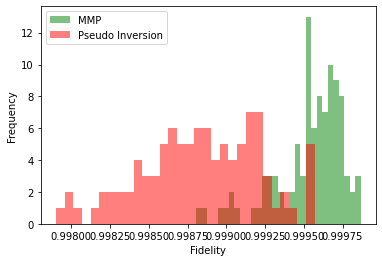

In [24]:
fig, ax = plt.subplots()
plt.hist(np.array(fidelities_mmp), bins=30, color='green', alpha=0.5, label='MMP')
plt.hist(np.array(fidelities_inv), bins=30, color='red', alpha=0.5, label='Pseudo Inversion')
plt.legend()
plt.xlabel('Fidelity')
plt.ylabel('Frequency')
plt.show()